In [1]:
import torch
import torch.nn as nn
import numpy as np

torch.manual_seed(0)

In [2]:
class DeepSetNetwork(nn.Module):
    def __init__(self, input_dim):
        super(DeepSetNetwork, self).__init__()
        self.linear1 = nn.Linear(input_dim, input_dim)
        self.init_weights()

    def init_weights(self):
        alpha, gamma = np.random.rand() * 2 - 1, np.random.rand() * 2 - 1
        weights = alpha * torch.eye(self.linear1.weight.shape[0]) + gamma * (
            torch.ones_like(self.linear1.weight)
        )
        self.linear1.weight.data = weights
        self.linear1.bias.data = torch.zeros_like(self.linear1.bias)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = torch.sum(x, dim=1)
        return x.view(-1, 1)


class SimpleLinearNetwork(torch.nn.Module):
    def __init__(self, layer_widths):
        super(SimpleLinearNetwork, self).__init__()
        self.layers = torch.nn.ModuleList()
        for a, b in zip(layer_widths, layer_widths[1:]):
            self.layers.append(torch.nn.Linear(a, b))

    def init_weights(self):
        for layer in self.layers:
            weights = torch.randn_like(layer.weight)
            layer.weight.data = weights
            layer.bias.data = torch.zeros_like(layer.bias)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        return self.layers[-1](x)

In [3]:
def sample_from_cube(npoints, ndim, side_length):
    vec = np.random.uniform(-side_length, side_length, (npoints, ndim))
    return torch.Tensor(vec)


def get_jacobians(points, model):
    """
    Compute the Jacobian of the model outputs with respect to its inputs for each input point.

    :param points: A tensor of shape (N, M) containing N points of dimension M.
    :param model: A PyTorch model that accepts inputs of shape (N, M) and outputs a tensor of shape (N, 1).
    :returns: A tensor of Jacobians of shape (N, M), where each row corresponds to the Jacobian of the model output with respect to the input point.
    """
    points.requires_grad = True
    output = model(points)
    output.backward(torch.ones_like(output))
    jacobians = points.grad
    return jacobians


def remove_duplicates(array):
    return np.unique(array, axis=0)

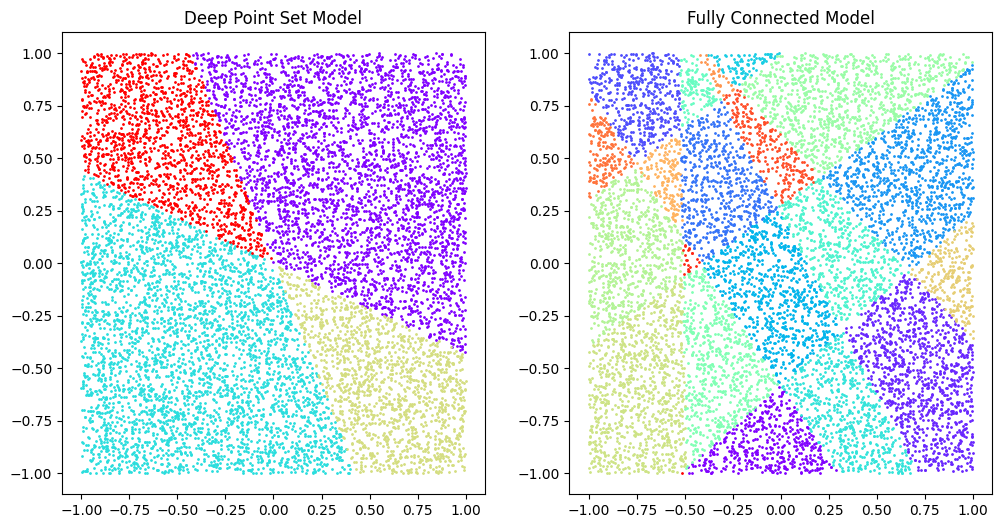

In [6]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming the functions DeepSetNetwork, SimpleLinearNetwork, sample_from_cube, 
# get_jacobians, and remove_duplicates are defined elsewhere

deep_set_model = DeepSetNetwork(2)
simple_model = SimpleLinearNetwork([2, 10, 1])
deep_set_points = sample_from_cube(10000, 2, 1)
simple_points = sample_from_cube(10000, 2, 1)

# Calculate Jacobians
deep_set_jacobians = get_jacobians(deep_set_points, deep_set_model)
deep_set_unique_jacobians = remove_duplicates(deep_set_jacobians)

simple_jacobians = get_jacobians(simple_points, simple_model)
simple_unique_jacobians = remove_duplicates(simple_jacobians)

# Classification of points by Jacobians
deep_set_classifications = defaultdict(list)
for point, jacobian in zip(deep_set_points, deep_set_jacobians):
    jacobian = tuple(np.round(jacobian, 5).tolist())
    if jacobian in [tuple(np.round(j, 5).tolist()) for j in deep_set_unique_jacobians]:
        deep_set_classifications[jacobian].append(point.tolist())

simple_classifications = defaultdict(list)
for point, jacobian in zip(simple_points, simple_jacobians):
    jacobian = tuple(np.round(jacobian, 5).tolist())
    if jacobian in [tuple(np.round(j, 5).tolist()) for j in simple_unique_jacobians]:
        simple_classifications[jacobian].append(point.tolist())

# Plot points with different colors for different Jacobians
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Generate unique colors for each classification
deep_colors = cm.rainbow(np.linspace(0, 1, len(deep_set_classifications)))
simple_colors = cm.rainbow(np.linspace(0, 1, len(simple_classifications)))

for i, (jacobian, curr_points) in enumerate(deep_set_classifications.items()):
    curr_points = np.array(curr_points)
    axes[0].scatter(curr_points[:, 0], curr_points[:, 1], color=deep_colors[i], s=1)
    axes[0].set_title("Deep Point Set Model")

for i, (jacobian, curr_points) in enumerate(simple_classifications.items()):
    curr_points = np.array(curr_points)
    axes[1].scatter(curr_points[:, 0], curr_points[:, 1], color=simple_colors[i], s=1)
    axes[1].set_title("Fully Connected Model")

plt.show()

In [ ]:
# colors = cm.rainbow(np.linspace(0, 1, len(deep_set_classifications)))
# for i, (jacobian, curr_points) in enumerate(deep_set_classifications.items()):
#     color = colors[i]
#     curr_points = np.array(list(curr_points))
#     plt.scatter(
#         curr_points[:, 0], curr_points[:, 1], color=color, label=f"{jacobian}", s=1
#     )

# # Plot line x = y
# x = np.linspace(-1, 1, 100)
# plt.plot(x, x, color="black")

# plt.show()

In [137]:
def sort_point_components(tensor):
    return torch.sort(tensor, dim=1).values

In [138]:
import math


def estimate_linear_regions(model, radius, n_points, point_dim):
    points = sample_from_cube(npoints=n_points, ndim=point_dim, side_length=radius)
    jacobians = get_jacobians(points, model).detach().numpy()
    unique_jacobians = remove_duplicates(np.around(jacobians, 10))
    return unique_jacobians.shape[0]


def estimate_linear_regions_using_fundamental_domain(
    model, radius, n_points, point_dim
):
    points = sample_from_cube(npoints=n_points, ndim=point_dim, side_length=radius)
    points = sort_point_components(points)
    jacobians = get_jacobians(points, model).detach().numpy()
    unique_jacobians = remove_duplicates(np.around(jacobians, 10))
    total = 0
    for jacobian in unique_jacobians:
        counts = np.unique(jacobian, return_counts=True)[1]
        total += math.factorial(point_dim) / np.prod(
            [math.factorial(count) for count in counts]
        )
    return total

In [139]:
import matplotlib.pyplot as plt


def run_experiment(num_models, point_dim, search_radius, base_num_points):
    num_points_adjusted_for_dimension = base_num_points**point_dim
    print(
        f"Running experiment with {num_models} models, {point_dim} input dimension, search radius {search_radius}, and {num_points_adjusted_for_dimension} points."
    )
    models = [DeepSetNetwork(point_dim) for _ in range(num_models)]
    all_ratios = []
    for i, model in enumerate(models):
        print(f"Model {i}")
        regular_sampling = estimate_linear_regions(
            model, search_radius, num_points_adjusted_for_dimension, point_dim
        )
        fundamental_domain_sampling = estimate_linear_regions_using_fundamental_domain(
            model,
            search_radius,
            num_points_adjusted_for_dimension // (math.factorial(point_dim)),
            point_dim,
        )
        ratio = fundamental_domain_sampling / regular_sampling
        all_ratios.append(ratio)
        print(
            f"Regular: {regular_sampling}, Fundamental domain: {fundamental_domain_sampling}, Ratio: {ratio}"
        )

    average_ratio = sum(all_ratios) / num_models
    print(f"Average ratio: {average_ratio}")

    return all_ratios


NUM_MODELS = 10
point_dim_to_ratios = {}
for point_dim in range(2, 3):
    point_dim_to_ratios[point_dim] = run_experiment(
        num_models=NUM_MODELS, point_dim=point_dim, search_radius=5, base_num_points=10
    )

Running experiment with 10 models, 2 input dimension, search radius 5, and 100 points.
Model 0
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 1
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 2
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 3
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 4
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 5
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 6
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 7
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 8
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 9
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Average ratio: 1.0


Input dimension 2: mean 1.0, variance 0.0


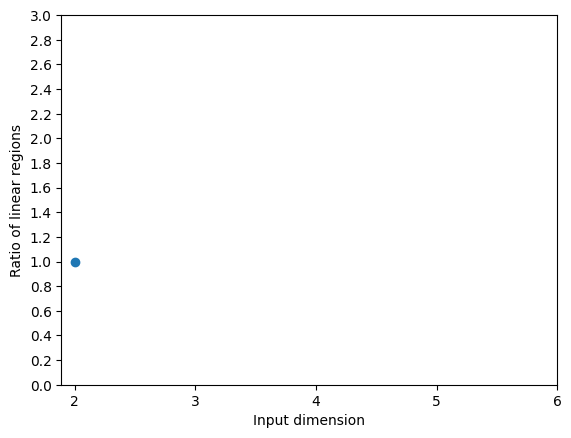

In [140]:
for k, v in point_dim_to_ratios.items():
    mean = sum(v) / len(v)
    variance = sum([(x - mean) ** 2 for x in v]) / len(v)
    print(f"Input dimension {k}: mean {mean}, variance {variance}")
    plt.errorbar(k, mean, yerr=variance**0.5, fmt="o")
plt.yticks(np.arange(0, 3.2, 0.2))
plt.xticks(range(2, 7))
plt.xlabel("Input dimension")
plt.ylabel("Ratio of linear regions")
plt.show()